## FIT5196 Assessment 2
#### Student Name: Ed Farrell
#### Student ID: 28629396

Date: 27/09/2017

Version: 1.0

Environment: Python 2.7.13 and Jupyter notebook

Libraries used: please include the main libraries you used in your assignment here, e.g.,:
* re (for regular expression, included in Anaconda Python 2.7)
* os (for directory management and creation)
* json (for parsing JSON files)
* collections (for Counter function, and OrderdDict for ordered dictionaries)
* copy (for creating deep copies of variables)
* python-Levenshtein (for calculating Levenshtein scores as part of cleaning duplicate / mis-entered data)
> <font color=red>This library __is not included in the standard Anaconda distribution__; setting CondaForge as an acceptable channel in Anaconda Navigator will allow installation of the library through the Navigator GUI.</font> <br> Read here for more information https://docs.anaconda.com/anaconda/navigator/tutorials/manage-channels
* pprint (for pretty print functionality)
* decimal (to support easy decimal formatting for displaying numerical data)
* pandas (funnily enough, we need to import Pandas to use Panda dataframes)
* numpy (additional functionality support for Pandas/MatPlotLib)
* matplotlib (graphing support for Pandas via the pyplot package)
* IPython.display (for better print visualisations of dataframes)
* seaborn (for a matplotlib-based visualisation suite with great graphics)
* sklearn (for linear regression modelling, and the train-test module)

## 1. Introduction

This assessment aims to wrangle a large set of property sales records stored in an unknown format, while also dealing with unknown & unforseen data quality issues. This assessment can thus be split into two distinct major tasks, namely
<br> i. Parsing property sales data stored in "data.dat", and
<br>
ii. Data auditing and cleansing

Initial problems arise due to the nature of the data file "data.dat" - the .dat filetype is a generic filename, most often as a  binary data file. A visual inspection of the file using the Notepad++ editor, however, shows strings of text surrounded by a mixture of colons and braces - suggesting a JSON file. This assumption was tested by importing as a JSON file, resulting in a successful file read by json.load.

The file contains a number of otentially 'dirty' elements; however, due to the nature of the data in question, there were no easy ways to identify whether this was intentional or not. yr_renovated, for example, may have NaN due to a renovation date not being entered, or because the property had simply not been renovated. A property may be listed multiple times, but this may either be obfuscation of a duplicate element or a property being relisted again for sale. As such, please see the relevant subsections for explanations of what decision was taken for the elements in question.

There was also a significant issue with outlier detection and removal, and the subsequent linear regression. Due to not having a background in data modelling, I was unable to successfully implement code that would remove bi-/multivariate outliers, instead opting for a mix of automated univariate outlier removal and additional graphical interpretation of bivariate graphing solutions. Linear regression has, frankly, not been taught well enough in this subject for me to be entirely confident in my linear regression models. Moving forward, it is my belief that this assessment will have to be adjusted for future cohorts to deal with the fact that this assessment requires significant prior knowledge.

## <center><font color=red>A note regarding global flags relating to this assessment</font></center>
It's important to note that there are certain flags through this assessment that will require changes by hand if particular outputs or outcomes are sought. Of note is the 'ind_drop' flag (default: False) at the start of __Section 5. Handling Duplicates__ and especially the 'auto_outliers' flag (default: False) at the start of __Section 6. Removing Outliers__.

## 2.  Import libraries and data

#### 2a. Importing Python libraries

See the initial section of this assignment for a library list with information on the purpose of relevant libraries.

In [1]:
# Import statements
import re
import os
import json
from collections import Counter
from collections import OrderedDict
import copy
from pprint import pprint
import Levenshtein as lscore
import pandas as pd
from decimal import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from IPython.display import display
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Notebook-wide formatting & modifications
getcontext().prec = 4 # Sets the global level of precision for decimal

%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize']=(10,10)

# Pandas display setting modifications - sets the level of precision to 6, and also forces all floats to display to 2
# decimal places, rather than using scientific notation.
pd.set_option('precision',5)
pd.options.display.float_format = '{:.2f}'.format

# Handles Panda chained errors
pd.options.mode.chained_assignment = None

#### 2b. Importing the original datafile

Examining the data.dat file using Notepad++ suggests that the data stored in the .dat file is actually a concatenated series of JSON files. As such, the data is read into python using 'open', and is then transferred into a Python dataframe. This dataframe is normalised for the JSON format using the 'json_normalize' package attached to Pandas.

By calling df.head(5), we show the first 5 rows of the dataframe to get an idea of the data that we have initially been provided with. The attributes' data types is then displayed to further assist in understanding the initial data. We can see that the attributes consists of stores of 'object' (string), 'int64' (integer), and 'float64' (float) data, which may have to be changed based on task requirements later on.

In [2]:
with open('data.dat') as data_file:    
    data = json.load(data_file)
    
df = pd.DataFrame(data)

In [3]:
from pandas.io.json import json_normalize
df = json_normalize(data, 'houses')

In [4]:
display(df.head(3))

,address,area,condition,date,floors,price,rooms,view,waterfront,yr_built,yr_renovated
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA","{u'sqft_basement': 0, u'sqft_above': 1340, u's...",3,20140502T000000,1.50,313000.00,Number of bathrooms: 1.5; Number of bedrooms: 3,0,0,1955,nan
1,"709 W Blaine St, Seattle, WA 98119, USA","{u'sqft_basement': 280, u'sqft_above': 3370, u...",5,20140502T000000,2.00,2384000.00,Number of bathrooms: 2.5; Number of bedrooms: 5,4,0,1921,nan
2,"26206-26214 143rd Ave SE, Kent, WA 98042, USA","{u'sqft_basement': 0, u'sqft_above': 1930, u's...",4,20140502T000000,1.00,342000.00,Number of bathrooms: 2.0; Number of bedrooms: 3,0,0,1966,nan


In [5]:
print df.dtypes

address          object
area             object
condition         int64
date             object
floors          float64
price           float64
rooms            object
view              int64
waterfront        int64
yr_built          int64
yr_renovated    float64
dtype: object


In [6]:
print df.describe()

       condition  floors       price    view  waterfront  yr_built  \
count    4601.00 4601.00     4601.00 4601.00     4601.00   4601.00   
mean        3.45    1.51   534523.98    0.24        0.01   1970.79   
std         0.68    0.54   571601.59    0.78        0.08     29.73   
min         1.00    1.00        0.00    0.00        0.00   1900.00   
25%         3.00    1.00   309950.00    0.00        0.00   1951.00   
50%         3.00    1.50   453500.00    0.00        0.00   1976.00   
75%         4.00    2.00   650000.00    0.00        0.00   1997.00   
max         5.00    3.50 26590000.00    4.00        1.00   2014.00   

       yr_renovated  
count        229.00  
mean        1995.71  
std           18.59  
min         1912.00  
25%         1988.00  
50%         2001.00  
75%         2009.00  
max         2014.00  


#### 2c. Defining notebook functions

Custom functions written during the construction of this notebook will be stored here so that they can be called as necessary from the moment that the data is being manipulated.

In [7]:
# checkNaNs is used to check whether a dataframe has NaN values, returning the occurence count for each column with NaN values.
# A function has been constructed so that extracted dataframes can be checked more simply, as well as being able to verify that
# a dataframe has been cleaned successfully later on.
def checkNaNs(dataframe):
    if dataframe.isnull().values.any() == True:
        print "There are NaN values present in the dataframe."
    elif dataframe.isnull().values.any() == False:
        print "There are no NaN values present in the dataframe!"
    for i in df:
        value = df[str(i)].isnull().sum()
        if value != 0:
            print i, 'has', value, 'NaN values present, or approximately', (Decimal(str(value))/Decimal(str(df.shape[0]))*100), 'percent of the entire body of data.'

# checkEnds is used to check whether leading or trailing non-alphanumeric characters are present each element of each column in
# the dataframe. If 
def checkEnds(dataframe):
    ends_count = 0
    ends_attrs = []
    for attr in dataframe:
        flag = False
        end_flag = False
        for elem in dataframe[attr]:
            temp_store = []
            if not str(elem)[0].isdigit() and not str(elem)[0].isalpha():
                flag = True
            if not str(elem)[-1].isdigit() and not str(elem)[-1].isalpha():
                end_flag = True
        if flag == True:
            print attr,"has leading errors present."
            ends_count += 1
        if end_flag == True:
            print attr,"has tailing errors present."
            ends_count += 1
        if flag or end_flag == True:
            ends_attrs.append(attr)
    if len(ends_attrs) == 0:
        print "No leading/trailing errors detected."

# uniqueCounter returns a dictionary for the nominated attribute in a particular dataframe, where the keys are the elements in
# the attribute and the related value is the number of times that key occurs in the attribute. If the display argument is passed
# as True, uniqueCounter will return the key:value pairs in a key-sorted format (i.e. 1:3, 2:6, 3:5, 4:7)
def uniqueCounter(dataframe, attr, display):
    dict_count = dict(Counter(dataframe[attr]))
    if display == True:
        print attr, ": Number of occurences\n-------------------------------"
        for k,v in sorted(dict_count.iteritems()):
            print k,':',v
    elif display == False:
        return dict_count

# levenshteinClean is used to assess the likelihood that a particular element of a specified attribute is a mis-spelled variant
# of a present correct value, using Levenshtein distance scoring. This function was originally designed to manage mis-spelled
# city entries, but has been designed to be attribute agnostic, so long as enough occurences exist to define 'anchor' elements.
# If a non-'anchor' element can be connected to multiple anchors, it is associated with the closest-scoring anchor and then
# removed from the pool of possible associations.
def levenshteinClean(dataframe, attr, display):
    # Creates a uniqueCounter variable for the selected attribute, and which will be used as the data for determining potentially
    # mis-typed entries in the attribute.
    uniqCountVar = uniqueCounter(dataframe, attr, False)
    rename_dict = {}
    taken_list = []
    anchor_list = []
    anchor_occurence = 5
    # Iterates across all unique values in the dataframe column. Each value that occurs more than 5 times is considered an 'anchor'
    # against which all other elements that occur 5 times or less are compared, with a Levenshtein score compiled for each pair. On
    # this score, the function determines whether the or all Levenshtein scores of 3 or less
    for score in range(1,4,1):
        for term, occur in uniqCountVar.iteritems():
            if occur > anchor_occurence:
                # Identifies an anchor against which all unique elements of the column will be Levenshtein scored against. Elements
                # must occur more than 5 times in the column before they can be classed as anchors. This figure was chosen on the
                # assumption that any value lower than this does not hold enough occurences to be considered a 'safe' enough option.
                anchor = copy.copy(term)
                anchor_len = len(anchor)
                anchor_list.append(anchor)
                # Iterates again through the elements of the column, identifying a Levenshtein score for each element against the anchor.
                for sub_term, sub_occur in uniqCountVar.iteritems():
                    if sub_occur <= anchor_occurence:
                        check_string = copy.copy(sub_term)
                        check_len = len(check_string)
                        # Establishes the difference in length between the two strings, and stores this value as a positive integer
                        # in dist.
                        if anchor_len == check_len:
                            dist = 0
                        elif anchor_len > check_len:
                            dist = anchor_len - check_len
                        else:
                            dist = check_len - anchor_len
                        # Creates a Levenshtein score for each anchor:element iteration.
                        leven_score = lscore.distance(anchor, check_string)
                        # Handles any occurence where the anchor is checking against itself.
                        if leven_score == 0:
                            pass
                        # If the Levenstein score (adjusted to include additional characters) is in the range 1 to 3, and the first
                        # letter is the same for both strings, then a case of mis-typed data is assumed. With each score 'tier', any
                        # word that occurs as a potential mis-type is added to a list so that it is not re-checked. This decision
                        # was made to handle false positives that may occur with an anchor:element pair where the element was also
                        # part of an earlier pair with a lower Levenshtein score.
                        if (leven_score) == (score + dist/2) and anchor[0] == check_string[0] and check_string not in taken_list:
                            taken_list.append(check_string)
                            rename_dict[check_string] = anchor
                            if display == True:
                                print anchor, check_string, leven_score
    if len(rename_dict) == 0:
        print "No values with a close-enough Levenshtein score detected."
    if len(rename_dict) > 0:
        dataframe[attr].replace(rename_dict, inplace=True)
        print "The following terms on the left were replaced with the correct term on the right."
        for k,v in rename_dict.iteritems():
            if len(k) > 13:
                print k+'  '+'\t', v
            else:
                print k+'  '+'\t\t', v


# A quick funtion to return rounding capabilities for floats, rounding on the value provided for the increment argument.
def floatRound(values, increment):
    store = []
    if type(values) == list:
        for elem in values:
            store.append(round(elem / increment) * increment)
        return store
    else:
        return round(values / increment) * increment
    
# Transfers imputed prices to the original dataframe where the price value is missing.
def updatePrice(dataframe, new_price_df):
    # Reindex both dataframes
    dataframe.reset_index(drop=True, inplace=True)
    new_price_df.reset_index(drop=True, inplace=True)
    # Create store variables
    index_store = []
    
    # Create list of index values that need to have their price values updated
    for index in dataframe.loc[dataframe.price == 0].index.tolist():
        index_store.append(index)
    # Find the price that needs to be updated in the new_price_df
    for index in index_store:
        new_price = new_price_df['price'].iloc[index]
        # Uses living space as the check value:
        if dataframe['sqft_living'].iloc[index] == new_price_df['sqft_living'].iloc[index]:
            dataframe.set_value(index, 'price', new_price)

## 3. Separating concatenated columns

#### 3.a - Extract Address Data

Pulls data from the 'address' attribute, splitting this information into the relevant street, city, State & ZIP, and country data, and then creating new columns for these attributes filled with the relevant figures.

In [8]:
# Cretes empty lists that will be filled with the relevant data extracted from the 'address' column. These lists will then be
# called to create new columns based on their contents.
street = []
city = []
statezip = []
country = []
address_group = [street, city, statezip, country]
# Regex breakdown: Returns four capture groups, as follows;
    # Group 1: The first string starting with either a digit 0-9 or a captial letter, proceeding until a comma is detected.
    # Group 2: Starts with a capital letter, followed by one to many lower-case letters,then zero to infinite letters (upper-
    # or lower-case) and spaces. Designed to handle cities with hyphenated names, or names containing more than one word.
    # Group 3: Two capital letters (indicating the abbreviated name of the state) as well as a single space and the first five
    # digits following this abbreviation. This capture group is designed to extract the 5-digit USPS ZIP standardised format,
    # rather than the extended 'ZIP+4' format. Ref: https://permanent.access.gpo.gov/gpo47009/rarc-wp-13-006.pdf
    # Group 4: Matches three upper-case letters (indicating country code, as per ISO 3166-1 alpha-3.)
            # Ref. https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3
address_regex = r'^([0-9A-Z][^,]+)|([A-Za-z][a-z-]+[A-Za-z ]*)|([A-Z]{2}[- ]{1}[0-9]{5})|([A-Z]{3})'

# Iterates through the 'address' column, separating the data present into four capturing groups based on the above regular
# expression. This data is cleaned of None values, commas, and empty strings, and then separated to the four lists created above
# before being transformed into dataframe columns.
for i in df['address']:
    full_details = re.split(address_regex, i)
    becleaned = [None, ', ', '']
    full_details = [elem for elem in full_details if elem not in becleaned]

    street.append(full_details[0])
    city.append(full_details[1])
    statezip.append(full_details[2])
    country.append(full_details[3])

# Writes the contents of street, city, statezip, and country to new dataframe columns. The contents of these columns are also
# given a final pass-over with either Pandas' .str.title() or .str.upper() to ensure data consistency.
try:
    df['street'] = street
    df['street'] = df['street'].str.title()
    df['city'] = city
    df['city'] = df['city'].str.title()
    df['statezip'] = statezip
    df['statezip'] = df['statezip'].str.upper()
    df['country'] = country
    df['country'] = df['country'].str.upper()
except:
    print "Error when writing new address columns!"

if 'street' and 'city' and 'statezip' and 'country' in df.columns.tolist():
    print 'Address column data successfully extracted!'
    df = df.drop('address', axis=1, errors='ignore')
    if 'address' not in df.columns.tolist():
        print 'Address column dropped.'

Address column data successfully extracted!
Address column dropped.


#### 3b. Extract Room Data

Pulls data from the 'rooms' attribute, splitting this information into the relevant bedrooms and bathrooms data, and then creating new columns for bedrooms and bathrooms filled with the relevant figures.

In [9]:
# Regex breakdown: Returns two capture groups, as follows;
    # Group 1: The first string of any length of numerical characters following 'bathrooms: ', including full stops to handle
    # fractions of rooms.
    # Group 2: The first string of any length of numerical characters following 'bedrooms: ', including full stops to handle
    # fractions of rooms.
rooms_regex = r'bathrooms: ([0-9.]+)|bedrooms: ([0-9.]+)'

# Empty lists that will be used to create new dataframe columns once they are filled.
bedrooms = []
bathrooms = []

# Iterates through 'rooms', extracting groups matching the rooms_regex regular expression using re.finditer, and then assigns
# the matching group to the relevant list. As finditer returns None if a capturing group is not met, and rooms_regex features 
# two capturing group for bedrooms and bathrooms, an iterative search can be used to identify which value refers to which room
# style.
for i in df['rooms']:
    tester = re.finditer(rooms_regex, str(i))
    printlist = []
    count = 0
    for match in tester:
        if tuple(match.groups())[0] == None:
            bedrooms.append(tuple(match.groups())[1])
        else:
            bathrooms.append(tuple(match.groups())[0])

# Writes the extracted data to new columns in the dataframe.
try:
    df['bathrooms'] = bathrooms
    df['bedrooms'] = bedrooms
except:
    print "Something went wrong when writing new rooms columns!"
    
# Removes the 'rooms' column only if both 'bathrooms' and 'bedrooms' are present as attributes in the dataframe.
if 'bathrooms' and 'bedrooms' in df.columns.tolist():
    print 'Rooms columns successfully extracted!'
    df = df.drop('rooms', axis=1)
    if 'rooms' not in df.columns.tolist():
        print 'Rooms column dropped.'

Rooms columns successfully extracted!
Rooms column dropped.


#### 3c. Extract Area Data

Pulls data from the 'area' attribute, splitting this information into the relevant sqft_basement, sqft_above, sqft_living, and sqft_lot data, and then creating new columns for these attributed filled with the relevant figures.

In [10]:
# Regex breakdown: Returns four capture groups, as follows;
    # Group 1: The first string of any length of numerical characters following "sqft_basement': ". Allocated to 'sqft_basement'
    # Group 2: The first string of any length of numerical characters following "sqft_above': ". Allocated to 'sqft_above'
    # Group 3: The first string of any length of numerical characters following "sqft_lot=". Allocated to 'sqft_living'
    # Group 4: The first string of any length of numerical characters following "\\ ". Allocated to 'sqft_lot'
    # Note that group 3 and 4 pull their data from the string format "u'sqft_living/sqft_lot=xxxx\\ yyyy', returning "xxxx" and
    # "yyyy" respectively
area_regex = r'sqft_basement\': ([0-9]+)|sqft_above\': ([0-9]+)|sqft_lot=([0-9]+)|\\\\ ([0-9]+)'

# Empty lists that will be used to create new dataframe columns once they are filled.
sqft_basement = []
sqft_above = []
sqft_living = []
sqft_lot = []
sqft_all = [sqft_basement, sqft_above, sqft_living, sqft_lot]

# Iterates through 'area', extracting groups matching the area_regex regular expression using re.finditer, and then assigns
# the matching group to the relevant list. As finditer returns None if a capturing group is not met, and rooms_regex features 
# two capturing group for bedrooms and bathrooms, an iterative search can be used to identify which value refers to which room
# style.
for i in df['area']:
    tester = re.finditer(area_regex, str(i))
    count = 0
    for match in tester:
        if tuple(match.groups())[0] != None:
            sqft_basement.append(tuple(match.groups())[0])
        elif tuple(match.groups())[1] != None:
            sqft_above.append(tuple(match.groups())[1])
        elif tuple(match.groups())[2] != None:
            sqft_living.append(tuple(match.groups())[2])
        elif tuple(match.groups())[3] != None:
            sqft_lot.append(tuple(match.groups())[3])

# Writes the extracted data to new columns in the dataframe
#for i in sqft_all:
#    if len(i) == df.shape[0]:
try:
    df['sqft_basement'] = sqft_basement
    df['sqft_above'] = sqft_above
    df['sqft_living'] = sqft_living
    df['sqft_lot'] = sqft_lot
except:
    print "Something went wrong when writing new areas columns!"
    
# Removes the 'rooms' column only if both 'bathrooms' and 'bedrooms' are present as attributes in the dataframe.
if 'sqft_basement' and 'sqft_above' and 'sqft_living' and 'sqft_lot' in df.columns.tolist():
    print 'Area columns successfully extracted!'
    df = df.drop('area', axis=1)
    if 'area' not in df.columns.tolist():
        print 'Area column dropped.'


Area columns successfully extracted!
Area column dropped.


#### 3d. Reorganising the dataframe and datatypes

As columns have been both added and dropped from the dataframe, we take a moment to reindex the dataframe in the order presented in the assignment description (see the Table under _Task 1. Parsing the property sales data stored in <font color=blue>“data.dat”</font>_).

Once the dataframe has been re-ordered, we once again examine the first 5 rows using df.head(5) to ensure that the data in the new columns appears to be correct. Following this, we also check the attributes' individual data types. We can see that a number of new 'object' datatype attributes have been added to the dataframe. While some of these - for example, the 'address' sub-attributes - are best stored as strings, numerical attributes such as 'bedrooms', 'bathrooms', and the 'area' sub-attributes, will all benefit from having their data type changed to 'int64' (and 'float64' for bathrooms, which df.head() suggests uses .25 incremental measurements).

We can also see that waterfront, view, and condition are stored as integers - however, these are categorical scores and Pandas includes a category datatype. Therefore, we can also change their datatypes to category.

In [11]:
pref_order = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country', ]
df = df.reindex(columns = pref_order)
display(df.head(3))

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000.00,3,1.5,1340,7912,1.50,0,0,3,1340,0,1955,nan,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,20140502T000000,2384000.00,5,2.5,3650,9050,2.00,0,4,5,3370,280,1921,nan,709 W Blaine St,Seattle,WA 98119,USA
2,20140502T000000,342000.00,3,2.0,1930,11947,1.00,0,0,4,1930,0,1966,nan,26206-26214 143Rd Ave Se,Kent,WA 98042,USA


In [12]:
df.dtypes

date              object
price            float64
bedrooms          object
bathrooms         object
sqft_living       object
sqft_lot          object
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above        object
sqft_basement     object
yr_built           int64
yr_renovated     float64
street            object
city              object
statezip          object
country           object
dtype: object

In [13]:
# Iterates through the attributes (identified above as having an incorrect object datatype, rather than numeric), transforming
# each attribute to the correct numeric datatype. We also take the time to change price to integer values, rather than the float
# datatype that it is currently set at. Errors is set to coerce so that any elements that cannot be transformed to a numeric
# value will become a NaN value. We then check the editted attributes for NaN values after the transformation, looking for any
# NaN values on top of the 4372 NaN values identified previously in the yr_renovated attribute.
for attr in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot']:
    df[attr] = pd.to_numeric(df[attr], errors='coerce')
# Any NaN values in price that have somehow been missed will also have their values replaced with 0. This is done at this stage
# so that any imputation we perform later to replace the 0 values in price will also handle these values.
df['price'] = df['price'].fillna(0).apply(np.int64)

# Change categorical attributes to the correct datatype.
for attr in ['waterfront', 'view', 'condition']:
    df[attr] = df[attr].astype('category', ordered=True)

# Display the 'new' datatypes for the dataframe.
print '\n', df.dtypes


date               object
price               int64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront       category
view             category
condition        category
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated      float64
street             object
city               object
statezip           object
country            object
dtype: object


## 4. Managing initial errors

This section seeks to first identify missing or otherwise mis-entered data, and then handle it as necessary. There is a large number of missing price values, and given the value of imputing these missing values properly along with the added complexity it will be handled after this section.

#### 4a. Checking for missing values

We run checkNans on the dataframe to find any NaN values present in the dataframe, as well as checking for any data that may have had additional non-alphanumeric characters leading or trailing the data elements with checkEnds. By using df.describe(), we can also see the numerical data for applicable columns. Of note is price, bedrooms, and bathrooms - all three of these categories should hold a minimum value of greater than zero, and yet we can see that at least one row exists for each of these attributes where the value is zero. We will explore this issue later on.

In [14]:
checkNaNs(df)
checkEnds(df)
print
display(df.describe())

There are NaN values present in the dataframe.
yr_renovated has 4372 NaN values present, or approximately 95.02 percent of the entire body of data.
No leading/trailing errors detected.



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated
count,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,229.00
mean,534523.98,3.40,2.16,2139.22,14851.57,1.51,1827.45,312.01,1970.79,1995.71
std,571601.59,0.91,0.78,963.09,35880.59,0.54,862.16,464.11,29.73,18.59
min,0.00,0.00,0.00,370.00,638.00,1.00,370.00,0.00,1900.00,1912.00
25%,309950.00,3.00,1.75,1460.00,5001.00,1.00,1190.00,0.00,1951.00,1988.00
50%,453500.00,3.00,2.25,1980.00,7683.00,1.50,1590.00,0.00,1976.00,2001.00
75%,650000.00,4.00,2.50,2620.00,11000.00,2.00,2300.00,610.00,1997.00,2009.00
max,26590000.00,9.00,8.00,13540.00,1074218.00,3.50,9410.00,4820.00,2014.00,2014.00


#### 4b. Handling incorrect date figures

We need to check that the date information provided is correct. More specifically, we can see that the date information is in the format YYYY-MM-DD-T00:00:00. As date is object dataype, we can perform string indexes; that means that we should be able to extract specific subsections of the date information as required, so long as the data is formatted correctly. We start by first checking what range of years occur in the date attribute.

In [15]:
print Counter(str(i)[0:4] for i in df['date'])

# We can see that there are initially 4600 occurences of 2014 as the year, with one occurence where the year is '2305'. This is
# clearly not a correctly-formatted entry!

Counter({'2014': 4600, '2305': 1})


In [16]:
# Create lists of month:day associations, given that different years have a different range of days that make up that month.
thirty_days = [str(i).zfill(2) for i in range(1,31,1)]
thirty_months = ['09','04','06', '11']
thirty_one_days = [str(i).zfill(2) for i in range(1,32,1)]
thirty_one_months = ['01','03','05','07','08','10','12']
february_days = [str(i).zfill(2) for i in range(1,29,1)]
all_months = [str(i).zfill(2) for i in range(1,13,1)]

# Establish any bad year data. We can see that there is only one entry where the year recorded is not 2014; indeed, index 4335
# has a date of '23052014T000000'. We can see that 2014 occurs, and so the date data remaining is '2305'. There are 12 months,
# so we can say that the 23 must therefore represent the day value. Thus, the data should read '20140523T000000'.
print 'Errors with year data:'
for i in df['date']:
    # Establish an index value for each iteration. This will be used to reference any bad data, and will give us the key to set
    # proper values in its place.
    error_index = df[(df.date == i)].index[0]
    if str(i)[0:4] != '2014':
        print i, 'at index', error_index
        df.set_value(error_index, 'date', '20140523T000000')

# As with the code above, iterates through date to establish incorrect year data. Scans each row, checking that the month data
# matches the year data in the same string. We can see that index 4334 has a date '20140631T000000', or June 31st, 2014. As June
# only has 30 days, we can say that the error is with the 31. Setting the day value to '30' will result in the (assumed) correct
# date '20140630T000000'. This was chosen to legitimise the data while still keeping it as the final possible value of the month.
print 'Errors with month/day data:'
for i in df['date']:
    error_index = df[(df.date == i)].index[0]
    if i[4:6] in thirty_months:
        if i[6:8] not in thirty_days:
            print i, 'at index', error_index
    elif i[4:6] in thirty_one_months:
        if i[6:8] not in thirty_one_days:
            print i, 'at index', error_index
    elif i[4:6] == '02':
        if i[6:8] not in february_days:
            print i, 'at index', error_index


Errors with year data:
23052014T000000 at index 4335
Errors with month/day data:
20140631T000000 at index 4334


In [17]:
df.set_value(4335, 'date', '20140523T000000')
df.set_value(4334, 'date', '20140630T000000')

display(df.iloc[[4335, 4334]])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4335,20140523T000000,505000,3,2.25,1670,1596,2.00,0,0,3,1220,450,2002,nan,3019 30Th Ave W,Seattle,WA 98199,USA
4334,20140630T000000,248000,3,1.00,950,9400,1.00,0,0,4,950,0,1954,nan,3920 153Rd Ave Se,Bellevue,WA 98006,USA


#### 4c. Replacing missing data in the bedrooms and bathrooms attributes.

We can see that bedroom and bathroom have at least one occurence each where they are set to 0. Most notably, we can see that both of these properties occupy multiple floors, and have a high property price - suggesting that these zeroes are not correct, but instead represent missing data. 

In [18]:
# We use a if-condition df.loc to find the rows where either bathrooms or bedrooms are equal to zero. We can see that there are
# two properties where both bathrooms and bedrooms equal zero.
display(df.loc[(df.bathrooms == 0) | (df.bathrooms == 0)])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2365,20140612T000000,1095000,0,0.00,3064,4764,3.50,0,2,3,3064,0,1990,nan,814 E Howe St,Seattle,WA 98102,USA
3209,20140624T000000,1295648,0,0.00,4810,28008,2.00,0,0,3,4810,0,1990,nan,20418 Ne 64Th Pl,Redmond,WA 98053,USA


In [19]:
# As there are only two properties missing this data, we can impute the missing data by taking the mean average for properties
# with [plus/minus] 1.0 floors, more than zero bedrooms and bathrooms, and have a price with a $250,000 [plus/minus] range.
# While this may seem large, the first property (index 2365) only returns 18 matching properties. This was chosen as an acceptable
# sacrifice in terms of balancing a too-small population versus a population with a diminished correlation with the properties
# we are trying to impute room figures for.

#df[['bathrooms', 'bedrooms']].loc[[('bedrooms' > 0) & ('bathrooms' > 0) & ('price'[1045000:1145000]) & ('floors'[3:4])]].mean()
#df.loc[('price' in range(1045000,1145000)) & ('floors' in range(3, 5))]

mean_2365 = df[['bathrooms', 'bedrooms']].loc[(df['floors'].isin([2.50, 3.00, 3.50, 4.00, 4.50])) & (df['bedrooms'] > 0) & (df['bathrooms'] > 0) & df['price'].isin(range(845000, 1345000))].mean()
mean_3209 = df[['bathrooms', 'bedrooms']].loc[(df['floors'].isin([1.00, 1.50, 2.00, 3.00])) & (df['bedrooms'] > 0) & (df['bathrooms'] > 0) & df['price'].isin(range(1045648, 1545648))].mean()

print mean_2365,'\n\n',mean_3209

bathrooms   2.76
bedrooms    4.11
dtype: float64 

bathrooms   2.98
bedrooms    4.02
dtype: float64


In [20]:
# From this, we can see that the rounded replacement figures for the property at index 2365 should be bathrooms = 2.75, and
# bedrooms = 4. Likewise, index 3209 will need to be replaced with 3.00 bathrooms and 4 bedrooms. We perform these edits as so:
df.set_value(2365, 'bathrooms', 2.75)
df.set_value(2365, 'bedrooms', 4)
df.set_value(3209, 'bathrooms', 3)
df.set_value(3209, 'bedrooms', 4)

# We check that these edits occured successfully below.
display(df[['bathrooms', 'bedrooms']].iloc[[2365, 3209]])

,bathrooms,bedrooms
2365,2.75,4
3209,3.00,4


#### 4c.ii Handling incorrect data in bedrooms and bathrooms

We also quickly check to see that the data in bedrooms and bathrooms is correctly entered; we saw earlier that bedroom is type integer, and thus pass over it as we cannot check for incorrectly-entered data. However, bathrooms is type float, and thus is at a greater risk of mis-entered data due to 'bad' decimals. Thankfully however, we have also created a function to handle these errors - floatRound. As such, we run it over the data in bathrooms to clean any issue present.

In [21]:
# Iterates through the unique elements of df['bathrooms'], creating a key:value dictionary with the elements as keys and the
# rounded (to 0.25 increments) numbers as values. df.replace is then used to iterate through the attribute 'bathrooms', replacing
# the key occurences with the rounded values.

float_dict = {}
for element in df.bathrooms.unique():
    float_dict[element] = floatRound(element, 0.25)

df['bathrooms'].replace(float_dict, inplace=True)

#### 4d. Checking categorical data

We can use the uniqueCounter function to check to see the spread of data for certain attributes, more specifically attributes that might be considered categorical - that is, they present as one of a limited number of potential values. We disregard attributes with a range approaching unique for each property, instead looking to explore data like cities, condition, floors, bathrooms, etc.

In [22]:
for attr in ['city', 'condition', 'bathrooms', 'bedrooms', 'floors', 'waterfront', 'view']:
    uniqueCounter(df, attr, True)
    print '\n'

city : Number of occurences
-------------------------------
Algona : 5
Auburn : 175
Auburnt : 1
Beaux Arts Village : 1
Belleview : 1
Bellevue : 284
Bellvue : 1
Black Diamond : 9
Bothell : 33
Burien : 74
Carnation : 21
Clyde Hill : 11
Coronation : 1
Covington : 43
Des Moines : 58
Duvall : 42
Enumclaw : 28
Fall City : 11
Federal Way : 148
Inglewood-Finn Hill : 1
Issaguah : 1
Issaquah : 186
Kenmore : 66
Kent : 185
Kirkland : 186
Kirklund : 1
Lake Forest Park : 36
Maple Valley : 96
Medina : 11
Mercer Island : 86
Milton : 2
Newcastle : 33
Normandy Park : 18
North Bend : 50
Pacific : 6
Preston : 2
Ravensdale : 7
Redmond : 233
Redmonde : 1
Redmund : 1
Renton : 293
Samamish : 1
Sammamish : 175
Seaattle : 1
Seatac : 29
Seatle : 1
Seattle : 1571
Shoreline : 122
Skykomish : 3
Snogualmie : 1
Snoqualmie : 70
Snoqualmie Pass : 1
Sureline : 1
Tukwila : 29
Vashon : 29
Woodenville : 2
Woodinville : 113
Yarrow Point : 4


condition : Number of occurences
-------------------------------
1 : 6
2 : 32
3 : 

A quick perusal of the printout above shows issues with the city and bathrooms attributes - namely potential misspellings/duplicates, and values not keeping to the 0.25 increment standard suggested by the data respectively. We can use the levenshteinClean function to handle the dirty city data, and floatRound to handle incorrect figures in bathrooms.

#### 4d.i Cleaning city data

Firstly, we can see that there are a number of city names that only occur a few times and look to be misspellings of cities that occur with a much higher count. As such, we run levenshteinClean on 'city' to handle these errors.

In [23]:
levenshteinClean(df, 'city', False)

The following terms on the left were replaced with the correct term on the right.
Issaguah  		Issaquah
Redmonde  		Redmond
Auburnt  		Auburn
Snoqualmie Pass  	Snoqualmie
Seaattle  		Seattle
Seatle  		Seattle
Kirklund  		Kirkland
Samamish  		Sammamish
Belleview  		Bellevue
Woodenville  		Woodinville
Bellvue  		Bellevue
Coronation  		Carnation
Snogualmie  		Snoqualmie
Redmund  		Redmond
Sureline  		Shoreline


Now that we have cleaned the city names, we can begin to check any relationship errors between the 'city' and the 'statezip' attributes. Running the code below returns any ZIP code that is referenced by more than one city, the number of cities referencing the ZIP code, as well as the number of times that each city cites that particular ZIP code. From this, we can manually check whether these ZIP code associations are correct, or whether the relationship is incorrect.

In [24]:
# Variable declarations for checking city-ZIP code associations. Display handles the display of the ZIP codes, and min_multiples
# declares the minimum number of cities that a ZIP code must be called by to appear here.
multi_city_zips = {}
count = 0
display_store = []
display = False
min_multiples = 1

# Creates a store of all cities associated with any ZIP code that has more than one city associated with that code.
for zipcode in df.statezip.unique():
    zipcheck_df = df['city'].loc[df.statezip == zipcode]
    cities_with_zip = zipcheck_df.unique()
    if len(cities_with_zip) > min_multiples:
        count += 1
        multi_city_zips[zipcode] = [i for i in cities_with_zip]
        string_1 = str(zipcode)+"; Num of zipcode entries: "+str(len(df.loc[df.statezip == zipcode]))
        display_store.append(string_1)
        string_2 = str(cities_with_zip)+' '+str(len(cities_with_zip))
        display_store.append(string_2)
        for city in cities_with_zip:
            string_3 = city+' '+str(len(df.loc[(df.city == city) & (df.statezip == zipcode)]))
            display_store.append(string_3)
        display_store.append("--------------------------------------")


print "There were",count, "ZIP codes relating to more than one city detected."
if display == True:
    for line in display_store[:-1]:
        print line

There were 19 ZIP codes relating to more than one city detected.


#### 4e. Handling incorrect yr_built and yr_renovated data

While we have already established that a vast majority of the yr_renovated data is NaN, there is still data that can be utilised when cleaning the data. More specifically, we can explore whether the value for yr_renovated is greater than the value for yr_built.

An initial exploration shows that there are four properties that do not meet the condition __yr_built < yr_renovated__, i.e. where the year of renovation is earlier than the year of construction. A visual inspection of these four properties suggests that the logical option would be to reverse the yr_built and yr_renovated values.

Note that as yr_renovated must be float64 type (due to Pandas' int64 not being able to handle NaN values), we temporarily change the datatype of yr_built to float64, and then revert to int64 once the columns have had their data swapped.

In [25]:
df.loc[(df.yr_built > df.yr_renovated)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4340,20140502T000000,440000,4,2.25,2160,8119,1.00,0,0,3,1080,1080,1966,1913.00,12211 Se 65Th St,Bellevue,WA 98006,USA
4341,20140526T000000,690000,4,2.50,2700,8810,2.00,0,0,3,2700,0,2004,2003.00,11659 168Th Ct Ne,Redmond,WA 98052,USA
4342,20140508T000000,375000,6,2.25,3206,5793,2.00,0,0,3,3206,0,2012,1912.00,25921-25929 35Th Pl S,Kent,WA 98032,USA
4345,20140522T000000,850000,4,3.25,3090,6744,2.00,0,4,3,3090,0,2013,1923.00,19117-19123 Richmond Beach Dr Nw,Shoreline,WA 98177,USA


In [26]:
# Sets yr_built to float64 type
df['yr_built'] = df['yr_built'].astype('float64')

# Swaps the column values in yr_built and yr_renovated using np.where, where yr_built is greater than yr_renovated.
df.yr_built, df.yr_renovated = np.where(df.yr_built > df.yr_renovated, [df.yr_renovated, df.yr_built], [df.yr_built, df.yr_renovated])

# Sets yr_built back to int64 type.
df['yr_built'] = df['yr_built'].astype('int64')

#### 4f. Handling incorrect area attributes

We can see that sqft_living appears to be a combination of sqft_above added to sqft_basement. As such, we can state that for any row, the following statement should be true: __sqft_living = sqft_above + sqft_basement__. A simple conditional df.loc returns any rows where this condition is met.

We can see that there are two properties where __sqft_living = sqft_above + sqft_basement__ is not met. Index 4338 appears to have not added the sqft_basement value to sqft_living; we can say therefore that sqft_living should equal 1280 + 1420 = 2700. Index 4339 appears to not have a basement value present, but only 590 for sqft_above given a sqft_living value of 890. Therefore we can say that sqft_basement should equal 890 - 590 = 300.

These replacements were chosen working under the assumption that it would be more likely that where data is present in all three attributes, the more specific above-ground and basement measurements are more likely to have been inut correctly, but a value of 0 is assumed to be more likely a case of missing data than an additional 300 square feet being added to sqft_living. 




In [27]:
df.loc[df.sqft_living != df[['sqft_above', 'sqft_basement']].sum(axis=1)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4338,20140710T000000,670000,3,2.50,1280,1438,2.00,0,0,3,1280,1420,2003,nan,746 Boylston Ave E,Seattle,WA 98102,USA
4339,20140701T000000,202000,1,1.00,890,833,1.00,0,0,4,590,0,1926,nan,701-711 26Th Ave,Seattle,WA 98122,USA


In [28]:
df.set_value(4338, 'sqft_living', 2700)
df.set_value(4339, 'sqft_basement', 300)

df.iloc[[4338, 4339]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4338,20140710T000000,670000,3,2.50,2700,1438,2.00,0,0,3,1280,1420,2003,nan,746 Boylston Ave E,Seattle,WA 98102,USA
4339,20140701T000000,202000,1,1.00,890,833,1.00,0,0,4,590,300,1926,nan,701-711 26Th Ave,Seattle,WA 98122,USA


We can also take the time to see if there are any properties where a one-story property's living space is greater than the lot area. We can see that there are two properties that match these conditions (index 1728, 4339), and that sqft_above and sqft_basement correctly add up to the value for sqft_living. We therefore assume that there is a mis-entry of data, and that the value for sqft_lot is equal to sqft_living (that is, the property occupies the total value of the land it is situated on).

In [29]:
df.loc[(df.sqft_living > df.sqft_lot) & (df.floors == 1.00)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1728,20140602T000000,610000,5,2.50,3990,3839,1.00,0,0,4,1990,2000,1962,nan,431 26Th Ave E,Seattle,WA 98112,USA
4339,20140701T000000,202000,1,1.00,890,833,1.00,0,0,4,590,300,1926,nan,701-711 26Th Ave,Seattle,WA 98122,USA


In [30]:
df.set_value(1728, 'sqft_lot', 3990)
df.set_value(4339, 'sqft_lot', 890)
df.iloc[[1728, 4338]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1728,20140602T000000,610000,5,2.50,3990,3990,1.00,0,0,4,1990,2000,1962,nan,431 26Th Ave E,Seattle,WA 98112,USA
4338,20140710T000000,670000,3,2.50,2700,1438,2.00,0,0,3,1280,1420,2003,nan,746 Boylston Ave E,Seattle,WA 98102,USA


#### 4g.  Addressing zero values

We can again call on df.describe() to check for zero values. Once called, we see that price, waterfront, view, sqft_basement all have zeroes present. However, only price stands out as an issue - waterfront is a boolean category (so zero only means that a property does not have waterfront views), view indicates the quality of view (so it could simply have a horrible view), and properties can obviously exist without a basement. As such, we then need to find out how many rows have a listed price of zero, and their indices.

In [31]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated
count,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,4601.00,229.00
mean,534523.98,3.40,2.16,2139.53,14851.61,1.51,1827.45,312.08,1970.74,1996.77
std,571601.59,0.91,0.78,963.04,35880.58,0.54,862.16,464.09,29.75,16.34
min,0.00,1.00,0.75,370.00,638.00,1.00,370.00,0.00,1900.00,1934.00
25%,309950.00,3.00,1.75,1460.00,5001.00,1.00,1190.00,0.00,1951.00,1988.00
50%,453500.00,3.00,2.25,1980.00,7683.00,1.50,1590.00,0.00,1976.00,2001.00
75%,650000.00,4.00,2.50,2620.00,11000.00,2.00,2300.00,610.00,1997.00,2010.00
max,26590000.00,9.00,8.00,13540.00,1074218.00,3.50,9410.00,4820.00,2014.00,2014.00


In [32]:
price_zeroes = len(df.loc[df['price'] == 0])
price_zero_indices = df.index[df['price'] == 0].tolist()
print price_zeroes, 'zeroes present in price, representing',str(Decimal(str(price_zeroes))/Decimal(str(df.shape[0]))*100)[0:4]+'% of the total body of price data.'


248 zeroes present in price, representing 5.39% of the total body of price data.


## 5. Handling duplicates

We now take a moment to explore duplicate values; as we are looking at property analysis, it makes sense that we use the street address as the key value. An initial exploration of the data for duplicated 'street' entries returns 149 rows, including the first version - by removing the 'keep=False' argument, we see that these 149 properties come from a stock of 76 properties. 

However, a df.head of these duplicates highlights that not all attributes in each row have duplicated values. Indeed, if we remove 'street' as a specific parameter for df.duplicated, only one duplicate pair is returned - 1917 235th Ct Ne in Sammamish. As such, we can state that there is a large number of partial duplicates present. In the name of data integrity, this notebook assumes that if property address and date are not the same, then the property may have been relisted, or otherwise sold multiple times in the period. As such, we will use these two factors as the identifiers for duplicate properties.

A sorted representation of the duplicate values is shown below. Note that this only identifies the properties where date and street are both duplicates. From this, we can see two property duplicates - 1917 235th Ct Ne, Sammamish, and 606 5th St Se, Auburn.

As we are preparing to begin dropping properties, we will create a top-level variable all_drop_list; rows will be added to this list as necessary, and will all be dropped at once prior to running linear regression.

#### <font color=red>Important flag below!</font>

In [33]:
# Determines whether properties will be dropped on the fly, or just prior to starting the linear regression. Recommended to leave
# this as False.
ind_drop = False

In [34]:
# Stores a list of all property indexes that need to be dropped (due to being
# duplicates, outliers, etc.).
all_drop_list = []

In [35]:
street_duplicate = (df[df['street'].duplicated(keep=False)])
print len(street_duplicate), "'street' duplicates detected, from", len(df[df['street'].duplicated()]), "initial properties."

149 'street' duplicates detected, from 76 initial properties.


In [36]:
# 5-row head of a dataframe of all properties where 'street' is duplicated.
street_duplicate.sort_values('street').head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
3956,20140703T000000,425000,3,1.50,1400,1022,3.00,0,0,3,1400,0,2007,nan,1018 Ne 96Th St,Seattle,WA 98115,USA
4280,20140709T000000,440000,3,1.50,1270,1413,3.00,0,0,3,1270,0,2007,nan,1018 Ne 96Th St,Seattle,WA 98115,USA
475,20140512T000000,490000,2,2.50,1230,1391,2.00,0,0,3,870,360,2004,nan,106 24Th Ave E,Seattle,WA 98112,USA
2671,20140617T000000,479000,2,2.25,1230,932,2.00,0,0,3,1020,210,2004,nan,106 24Th Ave E,Seattle,WA 98112,USA
2239,20140610T000000,895000,5,2.50,2550,20875,1.00,0,0,4,1610,940,1953,nan,11034 Ne 26Th Pl,Bellevue,WA 98004,USA


In [37]:
# Below is the only duplicate set of properties where every column is duplicated.
df[df.duplicated(keep=False)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4336,20140522T000000,657500,3,2.50,2670,10496,2.00,0,0,3,2670,0,1989,nan,1917 235Th Ct Ne,Sammamish,WA 98074,USA
4337,20140522T000000,657500,3,2.50,2670,10496,2.00,0,0,3,2670,0,1989,nan,1917 235Th Ct Ne,Sammamish,WA 98074,USA


In [38]:
# The two duplicate sets of properties where the columns 'street' and 'date' are both duplicates, ordered by 'street'. We can see
# that the details for the two properties listed at 606 5th St SE vary wildly, including an additional floor in one, a price
# difference of almost $100,000, and different values for both bed- and bathrooms. As such, this suggests that instead two
# sub-properties (in this example, apartments or townhouses) within a single building or site have both been sold on the same
# day.
duplicate_df = df[df.duplicated(subset =('street', 'date'), keep=False)]
duplicate_df.sort_values('street')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4336,20140522T000000,657500,3,2.50,2670,10496,2.00,0,0,3,2670,0,1989,nan,1917 235Th Ct Ne,Sammamish,WA 98074,USA
4337,20140522T000000,657500,3,2.50,2670,10496,2.00,0,0,3,2670,0,1989,nan,1917 235Th Ct Ne,Sammamish,WA 98074,USA
1017,20140520T000000,300000,6,5.25,2860,5682,2.00,0,0,3,2860,0,1978,nan,606 5Th St Se,Auburn,WA 98002,USA
1024,20140520T000000,206000,4,2.00,1700,6025,1.00,0,0,3,1700,0,1978,nan,606 5Th St Se,Auburn,WA 98002,USA


In [39]:
# We can see that the full duplicates occur at 4336 and 4337. As both are the same, we chose the drop the latter of the two
# properties.
if 4337 in df.index:
    all_drop_list.append(4337)
    if ind_drop == True:
        df.drop(4337, inplace=True)
else:
    print "Index not present in the dataframe!"

# If ind_drop is set to true, will re-call the code to search for duplicates to
# show that the dataframe does not hold duplicates.
# Re-calling the code used to highlight the duplicate initially should show an
# empty display. We call it thus;
if ind_drop == True:
    df[df.duplicated(keep=False)]

In [40]:
print all_drop_list

[4337]


## 6. Detecting and removing outliers

Prior to imputing prices for the 248 missing price entries, it is important for us to remove any outliers that may skew the data that we will be using to determine appropriate replacement price data. We can perform a quick univariate outlier, but this will not provide effective enough data - as we are dealing with multivariate data, we cannot rely solely on univariate outliers but must also consider bi-/multi-variate identification options where possible.

We will initially identify univariate outliers using 1.5 $\times$ the IQR, which represents the mathematics behind visually identifying outliers through boxplots. This identification will be performed on price, bedrooms, bathrooms, sqft_living, and sqft_lot; we can state that sqft_above and sqft_basement are both components of sqft_living, and thus can be ignored. Likewise, as the cities all fall within a limited area (King County, Washington State), we ignore any of the 'address' attributes as they will not possess significant outliers. yr_renovated has a majority of NaN values, and so there is not enough information to establish significant outliers, and so is also ignored. Date is also dropped as the range is too small for us to be able to establish meaningful data. Given their categorical nature, I have also chosen to leave aside waterfront, view, and condition, as outliers in these areas will require bivariate visual analysis against price to make a clearer distinction.

We will then proceed to a mixed univariate and bivariate analysis using graphical/visual analysis, using a range of plot types relevant to the particular attribute.

In [41]:
# We quickly reset the index count, as follows (if ind_drop is set to true, i.e
# property duplicates have been removed);
if ind_drop == True:
    df.reset_index(drop=True, inplace=True)
    df.describe()

In [42]:
# Declares whether outliers will be removed automatically (True), or via graphical interpretation (False). 
auto_outliers = False

#### 6a. IQR outlier detection (non-graphical, univariate)

#### <font color=red>Note: This section WILL NOT RUN if the auto_outliers flag is set to False; to run the automatic outlier removal code, ensure that this flag is set properly above.</font>

In [43]:
if auto_outliers == True:
    # Identifies numerical categories from which IQR can be established. Certain categories have been removed due to the presence of
    # NaNs (yr_renovated), either consistent or unique data (country, address), categorical data (statezip, waterfront, view,
    # condition), and other data that presented issues in identifying outliers for (date, address, city).
    outlier_dict = {}
    uni_outlier_cats = ['price', 'bedrooms','bathrooms','sqft_living','sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']
    #details_format = ['q1', 'q3', 'iqr', 'out_min', 'out_max']

    # Iterates through the numerical attributes from the dataframe, generating Q1, Q3, IQR, and upper and lower outlier ranges.
    for attr in uni_outlier_cats:
        details_list = []
        q1 = df[attr].quantile(q=0.25)
        q3 = df[attr].quantile(q=0.75)
        iqr = q3 - q1
        out_min = (q1 - (1.5*iqr))
        out_max = (q3 + (1.5*iqr))
        for elem in (q1, q3, iqr, out_min, out_max):
            details_list.append(elem)
        outlier_dict[attr] = details_list

    print outlier_dict
    # We can see that a number of out_min values are negative; as such, we can ignore these values if we were to use outlier_dict as
    # the guide to outliers as all of these categories cannot possess negative values in the real world. Instead, we would only look
    # for outliers above the out_max point as all values greater than zero and below this point would be within the 'safe' zone.

In [44]:
if auto_outliers == True:
    # Iterates through the dataframe attributes with identified IQR figures generated above, extracting the index values of each
    # row that meets the outlier requirements for each attribute. The display flag will print out a frame for each attribute if set
    # to True.
    index_strings = []
    display = False
    for attr, outliers in outlier_dict.iteritems():
        upper = outlier_dict[attr][4]
        lower = outlier_dict[attr][3]
        print len(df.loc[(df[attr] > upper) | (df[attr] < lower)].index), "outliers in", attr
        index_strings.append((df.loc[(df[attr] > upper) | (df[attr] < lower)].index))
        if display == True:
            print df.loc[(df[attr] > upper) | (df[attr] < lower)]
            print "\n"

In [45]:
if auto_outliers == True:
    # Stores the index of each outlier for each attribute in a single list, which is then counted and placed in a dictionary.
    temp_list = []
    for index_store in index_strings:
        for index in index_store:
            temp_list.append(index)

    # Creates the count dictionary for the outlier indices. The higher the count, the greater the number of outliers raised by that
    # index's property. Cutoff determines the minimum number of univariate outliers that an index must meet for it to be considered
    # an 'acceptable' outlier.
    temp_list = Counter(temp_list)
    outlier_counts = copy.copy(temp_list)
    cutoff = 0
    counter = 0
    for key, value in temp_list.iteritems():
        if value <= cutoff:
            counter += 1
            del outlier_counts[key]    

In [46]:
if auto_outliers == True:
    # Given this information, we can set cutoff to 2 (i.e. outliers are classed as outliers if they meet 3 of the outlier conditions)
    # and that price is one such outlier (as price is the most important category for us to remove outliers from).
    price_outliers = []
    for row in df.loc[df['price'] > outlier_dict['price'][4]].index:
        price_outliers.append(row)

    outlier_indices = []
    for index, count in outlier_counts.iteritems():
        for price in price_outliers:
            if index == price:
                outlier_indices.append(int(index))
    print len(outlier_indices)

In [47]:
if auto_outliers == True:
    # Adds the elements of outlier_indices to all_drop_list, to be dropped prior to
    # running linear regression.
    for i in outlier_indices:
        all_drop_list.append(i)
    all_drop_list = set(all_drop_list)

In [48]:
if auto_outliers == True:
    # Drops the identified outliers fromm df.
    all_drop_list = list(all_drop_list)
    df.drop(df.index[all_drop_list], inplace=True)

In [49]:
if auto_outliers == True:
    # We print df.describe followed by the outlier_dict; for each category in outlier_dict, the fourth value represents the low
    # cutoff for outliers, and the fifth represents high cutoff (i.e. anything above or below, respectively, is an outlier). This
    # can be checked manually to confirm that the min and max concur with these outlier cutoffs.
    print df.describe(), '\n'
    for key, value in outlier_dict.iteritems():
        print key
        print '\t minimum:', value[3]
        print '\t maximum:', value[4]

#### 6b. Graphical outlier detection

In this section, we will explore a number of graphs displaying both univariate and bivariate outliers; from these points, and the information gleaned above, we will develop ranges outside of which any points will be classed as outliers for the purpose of removal.

#### 6b.i Continuous variable histograms
We start with the continuous variables sqft_living, sqft_lot, sqft_above, and sqft_below. These are plotted on histograms, with rug points included with the graph.


#### <font color=red>Note that this section WILL NOT BE CORRECT if the 'auto_outliers' flag is set to True; to run a graphical outlier detection, set this flag to false.</font>

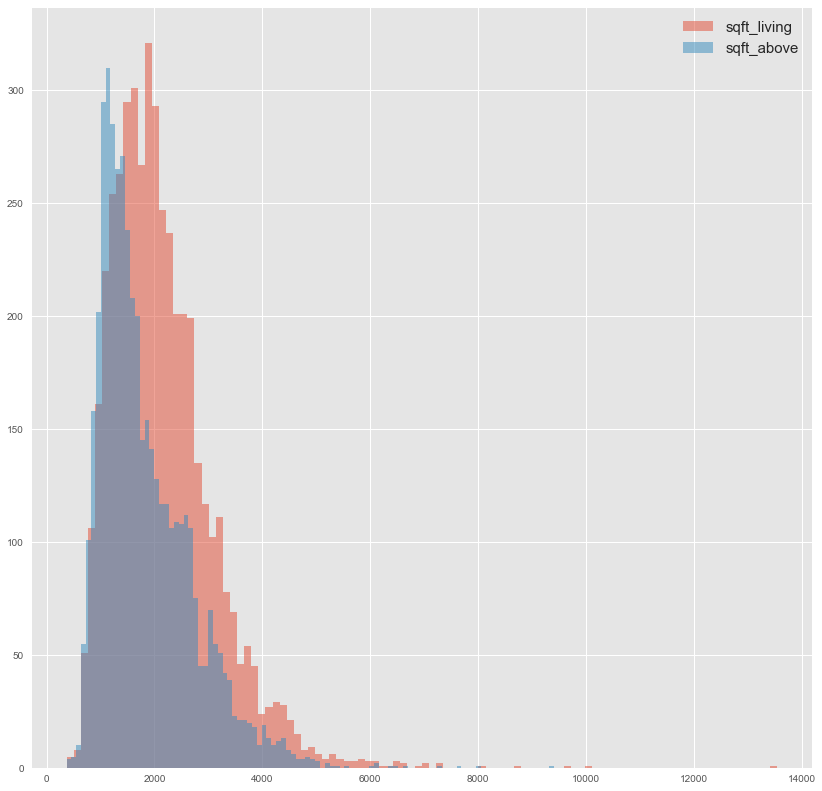

In [50]:
if auto_outliers == False:
    # A histogram showing the distribution of both sqft_above, and sqft_living. We can see that both attributes share a common
    # shape, with a strong skew to the right and a long tail leading out past the 10,000 square foot mark. This suggest that
    # outliers are present.
    # Note that pyplot was used here instead of Seaborn to allow for multiple histograms on the same image. Due to this, rugs are not
    # shown here.
    living = df["sqft_living"]
    above = df['sqft_above']
    bins = 100
    plt.figure(figsize=(14,14))
    plt.hist(living, bins, alpha=0.5, label='sqft_living')
    plt.hist(above, bins, alpha=0.5, label='sqft_above')
    plt.legend(loc='upper right', prop={'size': 15})
    plt.show()

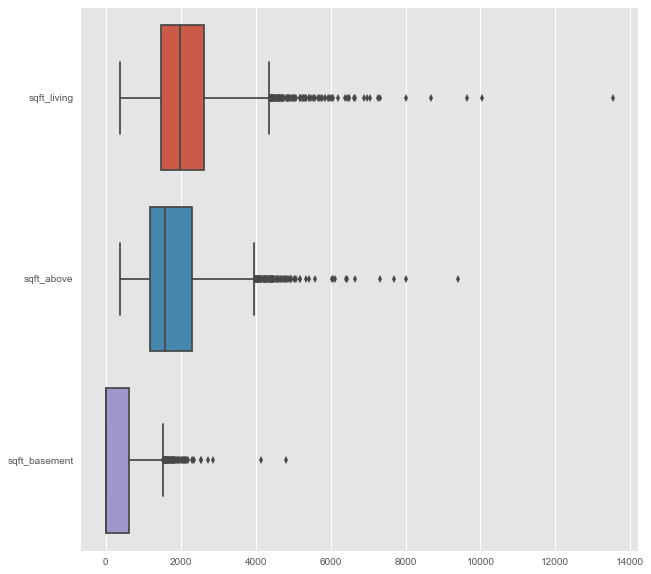

In [51]:
if auto_outliers == False:
    # We can also plot sqft_living, sqft_above, and also sqft_basement as a series of boxplots to visually identify the outliers.
    sns.boxplot(data=df[['sqft_living', 'sqft_above', 'sqft_basement']], orient='h')
    # This shows that outliers for sqft_living occur above approximately 4200 for sqft_living, approx 4000 for sqft_above, and
    # 1800 for sqft_basement. As such, a conditional statement for outliers regarding these variables might be
    for index in df.loc[(df['sqft_living'] > 4200) | (df['sqft_above'] > 4000) | (df['sqft_basement'] > 1800)].index:
        all_drop_list.append(index)

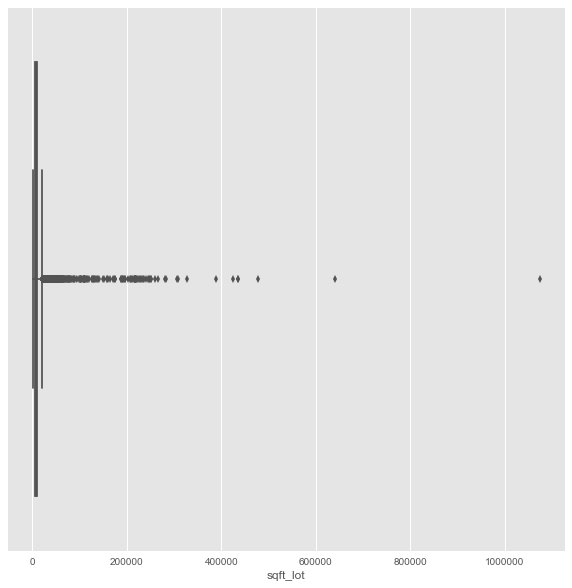

In [52]:
if auto_outliers == False:
    # We also create a boxplot for sqft_lot, as with the previous graphs. We can see that there is a very strong skew to the
    # right, with a number of outliers forming a very long tail. We take the time to check for properties where sqft_lot is
    # greater than 50,000 to see how many properties exist.
    sns.boxplot(df["sqft_lot"])

In [53]:
df[['sqft_lot']].loc[(df['sqft_lot'] > 50000)].describe()

,sqft_lot
count,188.00
mean,140842.18
std,116082.94
min,50233.00
25%,63020.00
50%,105481.00
75%,198850.75
max,1074218.00


In [54]:
if auto_outliers == False:
    # We can see that there are only 188 properties with over 50,000 square foot of land respectively (approx 4%). We can
    # therefore think of adding these points to all_drop_list to be removed, allowing for better visualisation. We also see a number
    # of properties with what appears to be a very small sqft_lot value.
    for index in df.loc[(df['sqft_basement'] > 50000)].index:
        all_drop_list.append(index)

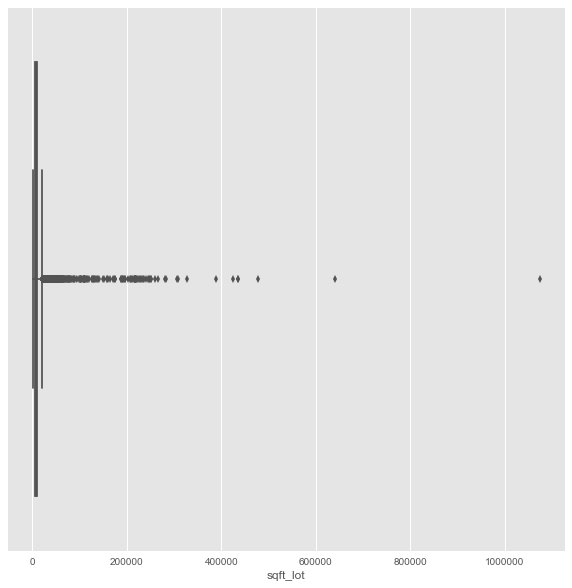

In [55]:
if auto_outliers == False:
    sns.boxplot(x='sqft_lot', data=df)

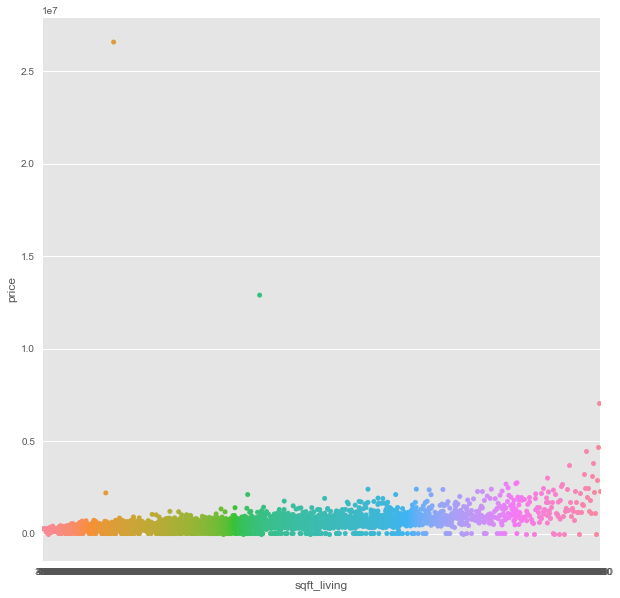

In [56]:
if auto_outliers == False:
    # From out initial inspection, we can see that sqft_living seems to carry the most value out of the area properties. As such, we
    # can also take the time to see what a scatterplot of sqft_living and price might look like - this will help us identify outliers
    # by price against sqft_living.
    sns.stripplot(x="sqft_living", y="price", data=df, jitter=True);
    # From this, we can see clear outliers for three datapoints at a value of over 5,000,000. However, there may be more points
    # that we are missing. We will also explore a boxplot for price to see what data we can gather.

    

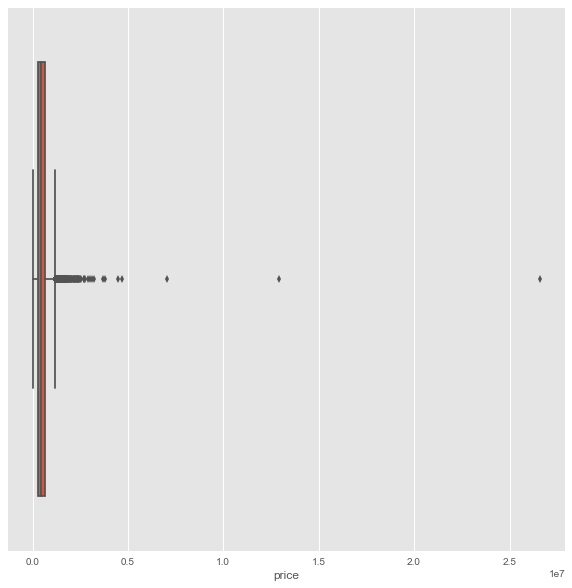

In [57]:
if auto_outliers == False:
    #sns.distplot(df['price'], bins=64, rug=True, kde=False)
    sns.boxplot(x='price', data=df)

We can immediately see a number of clear outliers above approx 0.25e7, or 2,500,000. As such, if we were to use a graphical method to detect outliers, this would be a shining example of what we would remove. We perform a df.loc for all price values greater than 2,500,000 to explore these points. We can see that there are only 16 properties that meet this condition, and so we 
also add them to all_drop_list;

In [58]:
if auto_outliers == False:
    len(df.loc[df['price'] > 2500000])

In [59]:
if auto_outliers == False:
    for index in df.loc[(df['price'] > 2500000)].index:
            all_drop_list.append(index)

#### 6b.ii Multivariate plots

In this section, we look to explore the discrete (bath- & bedrooms, and floors attributes) compared against price via scatterplots, and categorical variables (waterfront, view, and condition) against price via boxplots.


##### Discrete Variables v. Price

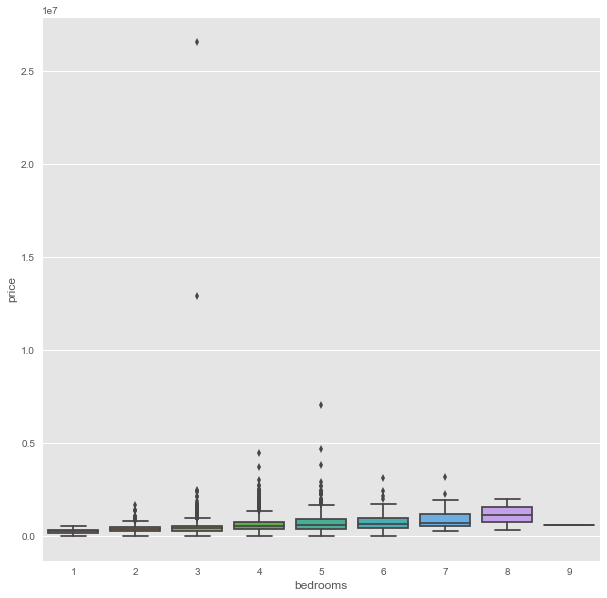

In [60]:
if auto_outliers == False:
    sns.boxplot(x="bedrooms", y="price", data=df);
    # From this, we can see that there appear to be outliers occuring at price > approx 0.22e7. Given how close this is to the data
    # previously identified in the 'price' boxplot, we leave it for now and continue out exploration with the other discrete
    #variables.

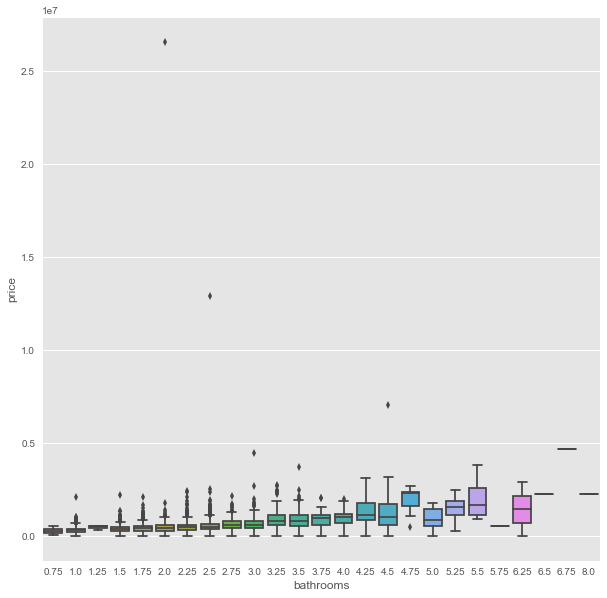

In [61]:
if auto_outliers == False:
    sns.boxplot(x="bathrooms", y="price", data=df);
    # Most outliers here seem to fall in the 0.1e7 - 0.12e7 range if bathrooms is less than 2.75. As such, we may set a conditional
    # statement to put all properties where bathrooms are less than 2.75 and price is higher than 1200000 in all_drop_list.
    for index in df.loc[(df['price'] > 1200000) & (df['bathrooms'] <= 2.75)].index:
            all_drop_list.append(index)

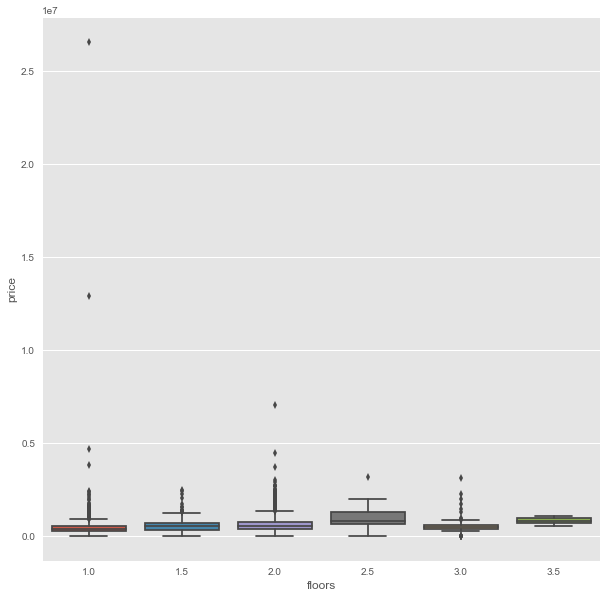

In [62]:
if auto_outliers == False:
    sns.boxplot(x="floors", y="price", data=df);
    # As with bathrooms, we can see that for properties with 2 or less floors, outliers occur where the price is greater than
    # approximately 1.5e7, or 1500000. As such, we can say that 
    for index in df.loc[(df['price'] > 1500000) & (df['floors'] <= 2.00)].index:
            all_drop_list.append(index)

##### Categorical Variables v. Price

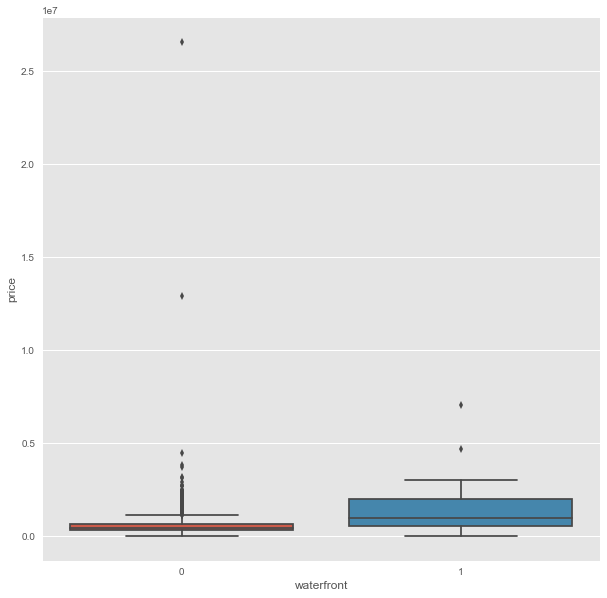

In [63]:
if auto_outliers == False:
    sns.boxplot(x="waterfront", y="price", data=df);
    # We can see that for properties with no waterfront, outliers appear to occur at prices of over 1.4e7, or 1400000. As such, we
    # can say that
    for index in df.loc[(df['price'] > 1400000) & (df['waterfront'] == 0)].index:
            all_drop_list.append(index)

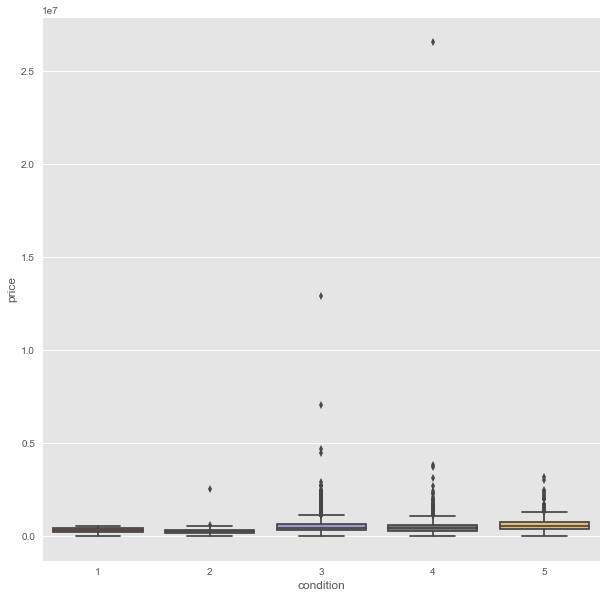

In [64]:
if auto_outliers == False:
    sns.boxplot(x="condition", y="price", data=df);
    # We can see that for all properties, no matter the condition, outliers appear to occur at price points already covered by
    # the other outlier detections. As such, we leave it.

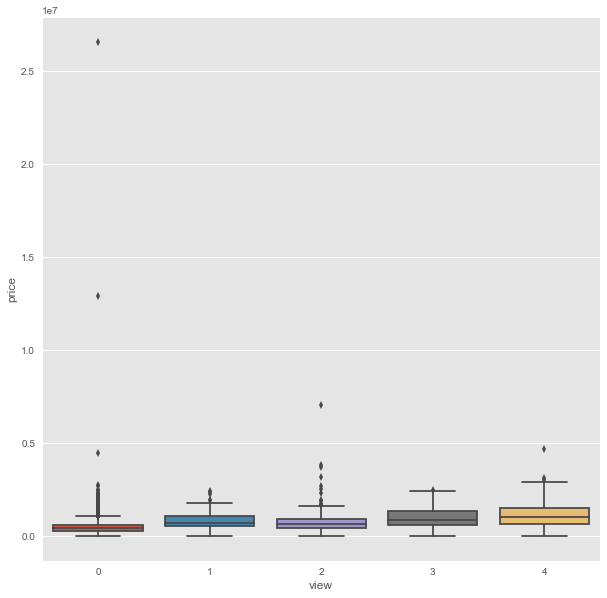

In [65]:
if auto_outliers == False:
    sns.boxplot(x="view", y="price", data=df);
    for index in df.loc[(df['price'] > 1400000) & (df['condition'] == 0)].index:
            all_drop_list.append(index)
    for index in df.loc[(df['price'] > 2400000) & (df['condition'] <= 2)].index:
            all_drop_list.append(index)
    # We can see two distinct groups here; 0 view has a significantly lower outlier cutoff than any other point, at approx
    # 1400000. We can also see that 1 or 2 view score seems to cut off around 2400000, and so we also have a conditional statement
    # to handle these.

In [66]:
# Having gone through the graphs, we are now ready to remove the outliers. We set all_drop_list and then reset it to list type,
# and then perform the drop as follows;
if auto_outliers == False:
    all_drop_list = list(set(all_drop_list))
    df.drop(df.index[all_drop_list], inplace=True)

## 7. Linear Regression

#### 7.a Building a training model

Prior to undertaking the linear regression, we need to drop certain attributes - due to their being a large body of data missing, yr_renovated is the first to go. sqft_above and sqft_basement combined make up sqft_living, and so it can be said that they are inter-dependent; as sqft_living contains the values for both attributes, we drop them. Specific street addresses are almost completely unique and so are dropped as well. Country, on the other hand, holds the same value for all properties and so is removed as well. Statezip is dropped due to the nature of the data - strings cannot be run through LinearRegression and so it is dropped. Categorical attributes - view, condition, and waterfront - are also dropped as they are not handled by the regression. As floors is an ordinal categorical attribute, we also drop it.


In this section we create a dataframe (dfna) where zeros in 'price' are transformed to NaNs, and then drop all rows where price is NaN. This will be used to train the linear regression model.

We will also create a dataframe (impute_df) which will have the missing 'price' filled with imputed values generated by a linear regression.

In [67]:
# Create a carbon copy of df; drop any attribute that isn't price, bathrooms,
# or sqft_living. Finally, replace 0s with NaN values and then drop rows
# containing these values.
dfna = df.copy() #[['price', 'bathrooms', 'sqft_living']]
dfna = dfna.drop([i for i in list(df) if i not in ['price','bathrooms','bedrooms','sqft_living']], axis=1)
dfna['price'].replace(0, np.nan, inplace=True)
dfna.dropna(subset = ['price'], inplace=True)

# As above, without droppping the NaN values. This will be a copy of
# the initial dataframe, where zero figues will be imputed later on.
impute_df = df.copy()
impute_df = impute_df.drop([i for i in list(df) if i not in ['price','bathrooms','bedrooms','sqft_living']], axis=1)

# As we cannot allow NaN values in the linear regression for price, we check
# isnull().sum() for both dataframes.
print dfna['price'].isnull().sum(), impute_df['price'].isnull().sum()

0 0


#### 7b. Training the  Linear Regression

In [68]:
# Creates a deep copy of dfna, and a LinearRegression object
model_for_impute_df = dfna.copy()
model_for_impute = linear_model.LinearRegression()
# Fits the dfna copy to the LinearRegression model
model_for_impute.fit(model_for_impute_df[[col for col in model_for_impute_df if col != 'price']], model_for_impute_df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
# Predicts imputed data for the impute_df dataframe
impute_df['price'][impute_df['price'] == 0] = model_for_impute.predict(impute_df.drop(['price'], axis=1))
impute_df.isnull().sum()
#print impute_df['price'].loc[impute_df['price'] < 10000]

price          0
bedrooms       0
bathrooms      0
sqft_living    0
dtype: int64

In [70]:
# Spin off an additional copy of the dataframe prior to running it through the
# linear regression model.
testing_df = df.copy()
testing_df = testing_df.drop([i for i in list(df) if i not in ['price','bathrooms','bedrooms','sqft_living']], axis=1)

# Testing the model developed on the full dataset
X_train, X_test, y_train, y_test = train_test_split(testing_df.iloc[:,:-1], testing_df.iloc[:,-1:],random_state=5196)
map(pd.np.shape, [X_train, X_test, y_train, y_test])
full_model = linear_model.LinearRegression()
full_model.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
testing_df.head(5)

,price,bedrooms,bathrooms,sqft_living
0,313000,3,1.50,1340
2,342000,3,2.00,1930
3,420000,3,2.25,2000
4,550000,4,2.50,1940
5,490000,2,1.00,880


In [72]:
# Testing with data stripped of NaN / zero values in the dfna dataframe
X_train, X_test, y_train, y_test = train_test_split(dfna.iloc[:,:-1], dfna.iloc[:,-1:],random_state=5196)
dfna_model = linear_model.LinearRegression(normalize=True) # Why normalise?
dfna_model.fit(X_train,y_train)
#print dnfa_model.score(X_test,y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [73]:
# Finally, testing the model on imputed data
X_train, X_test, y_train, y_test = train_test_split(impute_df.iloc[:,:-1], impute_df.iloc[:,-1:],random_state=5196)
impute_model = linear_model.LinearRegression()
impute_model.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [74]:
print "The r-squared score for the three linear regression models are as follows;"
print "\t i. r-squared score for the full dataset model is", full_model.score(X_test, y_test)
print "\n\t ii. r-squared score for the model for the dataset with no zeros in price is", dfna_model.score(X_test,y_test)
print "\n\t iii. r-squared score for the imputed price dataset model is", impute_model.score(X_test, y_test)

The r-squared score for the three linear regression models are as follows;
	 i. r-squared score for the full dataset model is 0.717130160195

	 ii. r-squared score for the model for the dataset with no zeros in price is 0.724045479386

	 iii. r-squared score for the imputed price dataset model is 0.723615678337


Checks the dataframe.describe() details to visually inspect the three generated dataframes that have had their r-squared scores generated, along with the original dataframe. The original datframe is also inspected after having its zero price values replaced with imputed scores.

In [75]:
impute_df.describe()

,price,bedrooms,bathrooms,sqft_living
count,4318.00,4318.00,4318.00,4318.00
mean,494303.50,3.35,2.08,1996.83
std,220472.28,0.88,0.70,739.13
min,7800.00,1.00,0.75,370.00
25%,327500.00,3.00,1.75,1430.00
50%,453750.00,3.00,2.25,1910.00
75%,616000.00,4.00,2.50,2490.00
max,1400000.00,9.00,5.75,4180.00


In [76]:
model_for_impute_df.describe()

,price,bedrooms,bathrooms,sqft_living
count,4086.00,4086.00,4086.00,4086.00
mean,494132.73,3.34,2.08,1995.51
std,223844.38,0.88,0.70,737.19
min,7800.00,1.00,0.75,370.00
25%,325000.00,3.00,1.75,1430.00
50%,452000.00,3.00,2.25,1910.00
75%,619300.00,4.00,2.50,2490.00
max,1400000.00,9.00,5.75,4180.00


In [77]:
dfna.describe()

,price,bedrooms,bathrooms,sqft_living
count,4086.00,4086.00,4086.00,4086.00
mean,494132.73,3.34,2.08,1995.51
std,223844.38,0.88,0.70,737.19
min,7800.00,1.00,0.75,370.00
25%,325000.00,3.00,1.75,1430.00
50%,452000.00,3.00,2.25,1910.00
75%,619300.00,4.00,2.50,2490.00
max,1400000.00,9.00,5.75,4180.00


In [78]:
updatePrice(df, impute_df)

In [79]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated
count,4318.00,4318.00,4318.00,4318.00,4318.00,4318.00,4318.00,4318.00,4318.00,195.00
mean,494303.47,3.35,2.08,1996.83,13834.55,1.49,1717.85,278.98,1970.32,1996.01
std,220472.28,0.88,0.70,739.13,34576.76,0.54,707.49,408.89,29.62,17.25
min,7800.00,1.00,0.75,370.00,638.00,1.00,370.00,0.00,1900.00,1934.00
25%,327500.00,3.00,1.75,1430.00,5000.00,1.00,1170.00,0.00,1950.00,1986.50
50%,453750.00,3.00,2.25,1910.00,7500.00,1.50,1530.00,0.00,1974.00,2000.00
75%,616000.00,4.00,2.50,2490.00,10435.50,2.00,2160.00,560.00,1996.00,2010.00
max,1400000.00,9.00,5.75,4180.00,1074218.00,3.50,4000.00,1780.00,2014.00,2014.00


## 8. Writing the imputed dataframe to CSV
In this final step, the program will write the 'impute_df' dataframe (where additional data has been imputed to account for missing/incorrect price information) to a CSV file.

In [80]:
# Writes the impute_df dataframe to a CSV file that is saved in the current working directory. Note that this only contains the
# columns used to produce an imputed model, not the full contingent of attributes stored in 'Farrell_28629396_ass2_data.csv'.
df.to_csv('Farrell_28629396_ass2_data.csv')